# Taylor-Couette Pseudospectrum test

Use parameters from [Hristova et al (2002, Phys Fluids)](https://aip.scitation.org/doi/abs/10.1063/1.1502658):

$$
k_z = \frac{\pi}{2}\\
\eta = 0.5\\
\mu = -1\\
\mathrm{Re} = 125
$$

Note that they use a different length unit, $[\mathrm{L}] = 2 \delta$, where $\delta = r_{out} - r_{in}$ is our length unit. However, they use the same velocity unit, so their time unit is also twice ours.

We change their parameters to their equivalent in our non-dimensionalization.

In [1]:
import numpy as np
from dedalus import public as de
from eigentools import Eigenproblem, CriticalFinder
import matplotlib.pyplot as plt

In [2]:
plt.style.use('prl')

In [3]:
nr = 32

# from Hristova et al (2002)
Re1 = 125
alpha = np.pi/2 # they call this beta

eta = 0.5
mu = -1
m = 0

# convert to our non-Dim
# all other params are dimensionless and thus the smae
Re1 *= 2
alpha *= 2

In [4]:
"""
delta = R2 - R1
mu = Omega2/Omega1
eta = R1/R2

scale [L] = delta
scale [T] = delta/(R1 Omega1)
scale [V] = R1 Omega1
"""
#derived parameters
R1 = eta/(1. - eta)
R2 = 1./(1-eta)
nu = 1./Re1

variables = ['u','ur','v','vr','w','wr','p']

#domain
r_basis = de.Chebyshev('r', nr, interval=[R1, R2])

bases = [r_basis]
domain = de.Domain(bases) 

#problem
problem = de.EVP(domain, eigenvalue='sigma', variables=variables)

#params into equations
problem.parameters['eta']=eta
problem.parameters['mu']=mu
problem.parameters['nu']=nu
problem.parameters['kz'] = alpha
problem.parameters['m'] = m

#Substitutions

"""
this implements the cylindrical del operators. 
NB: ASSUMES THE EQUATION SET IS PREMULTIPLIED BY A POWER OF r (SEE BELOW)!!!

Lap_s --> scalar laplacian
Lap_r --> r component of vector laplacian
Lap_t --> theta component of vector laplacian
Lap_z --> z component of vector laplacian

"""

problem.substitutions['A'] = '(1/eta - 1.)*(mu-eta**2)/(1-eta**2)'
problem.substitutions['B'] = 'eta*(1-mu)/((1-eta)*(1-eta**2))'

problem.substitutions['v0'] = 'A*r + B/r'       #background profile? forcing instead of forcing the boundaries
problem.substitutions['dv0dr'] = 'A - B/(r*r)'  #d/dr of background forcing

problem.substitutions['dtheta(f)'] = '1j*m*f'
problem.substitutions['dz(f)'] = '1j*kz*f'
problem.substitutions['dt(f)'] = 'sigma*f'

# assume pre-multiplication by r*r
problem.substitutions['Lap_s(f, f_r)'] = "r*r*dr(f_r) + r*f_r + dtheta(dtheta(f)) + r*r*dz(dz(f))"
problem.substitutions['Lap_r'] = "Lap_s(u, ur) - u - 2*dtheta(v)"
problem.substitutions['Lap_t'] = "Lap_s(v, vr) - v + 2*dtheta(u)"
problem.substitutions['Lap_z'] = "Lap_s(w, wr)"

# momentum equations
problem.add_equation("r*r*dt(u) - nu*Lap_r - 2*r*v0*v + r*v0*dtheta(u) + r*r*dr(p) = 0")
problem.add_equation("r*r*dt(v) - nu*Lap_t + r*r*dv0dr*u + r*v0*u + r*v0*dtheta(v) + r*dtheta(p)  = 0")
problem.add_equation("r*r*dt(w) - nu*Lap_z + r*r*dz(p) + r*v0*dtheta(w) = 0.")

#continuity
problem.add_equation("r*ur + u + dtheta(v) + r*dz(w) = 0")

#Auxillilary equations
problem.add_equation("ur - dr(u) = 0")
problem.add_equation("vr - dr(v) = 0")
problem.add_equation("wr - dr(w) = 0")

#Boundary Conditions
problem.add_bc("left(u) = 0")
problem.add_bc("right(u) = 0")
problem.add_bc("left(v) = 0")
problem.add_bc("right(v) = 0")
problem.add_bc("left(w) = 0")
problem.add_bc("right(w) = 0")


ep = Eigenproblem(problem)

2022-04-18 15:34:21,319 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2022-04-18 15:34:21,447 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


In [5]:
ep.solve(sparse=False)

In [6]:
def energy_norm(Q1, Q2):
    u1 = Q1['u']
    v1 = Q1['v']
    w1 = Q1['w']
    u2 = Q2['u']
    v2 = Q2['v']
    w2 = Q2['w']

    field = (np.conj(u1)*u2 + np.conj(v1)*v2 + np.conj(w1)*w2).evaluate().integrate()
    return field['g'][0]

Now because their time unit is twice ours, their growth rates and frequencies are twice ours. Here we scale our results by a factor of one half to match their plots.

In [11]:
k = 25

psize = 100
ps_real = np.linspace(-4,2,psize)
ps_imag = np.linspace(-3,3,psize)

In [13]:
ep.calc_ps(k, (ps_real, ps_imag), inner_product=energy_norm,maxiter=20)

In [31]:
clevels

array([-1.8, -1.5, -1.2, -0.9, -0.6, -0.3,  0. ])

In [33]:
clevels = np.linspace(-1.8,0,7)

And this reproduces their figure 7 (top panel) extremely well.

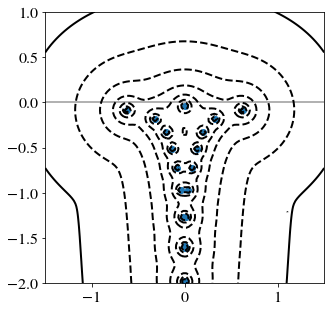

In [34]:
plt.figure(figsize=(5,5))
plt.scatter(ep.evalues_good.imag/2, ep.evalues_good.real/2)
plt.xlim(-1.5,1.5)
plt.ylim(-2,1)
plt.axhline(0,color='k',alpha=0.3)
plt.contour(ep.ps_imag/2, ep.ps_real/2, np.log10(ep.pseudospectrum.T/2),levels=clevels,colors='k')
#ax.set_xlim(-2,0.1)
#ax.scatter()